In [1]:
import pickle
with open('train_data.pkl',"rb") as f:
    data = pickle.load(f)

In [16]:
doc = data['a108558_a108558_v1_report']

In [17]:
len(doc['components'])

47

In [72]:
G = dgl.DGLGraph()

/home/soham/miniconda3/envs/vrd-iu/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [73]:
nodes = [comp['object_id'] for comp in doc['components']]

In [74]:
sorted(nodes)

[2352,
 2353,
 2354,
 2355,
 2356,
 2357,
 2358,
 2359,
 2360,
 2361,
 2362,
 2363,
 2364,
 2365,
 2366,
 2367,
 2368,
 2369,
 2370,
 2371,
 2372,
 2373,
 2374,
 2375,
 2376,
 2377,
 2378,
 2379,
 2380,
 2381,
 2382,
 2383,
 2384,
 2385,
 2386,
 2387,
 2388,
 2389,
 2390,
 2391,
 2392,
 2393,
 2394,
 2395,
 2396,
 2397,
 2398]

In [75]:
def load_feats(nodes):
    obj_id_map = {}
    tensors = []
    for idx,node in enumerate(nodes):
        tensors.append(torch.load(f"train_visual_features/{node}.pt",map_location=torch.device("cpu")).unsqueeze(0))
        obj_id_map[node] = idx
    return torch.cat(tensors,dim=0), obj_id_map

In [76]:
feats, obj_id_map = load_feats(nodes)

/tmp/ipykernel_39351/3225281269.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors.append(torch.load(f"train_visual_features/{node}.pt",map_location=torch.device("c

In [77]:
feats.shape

torch.Size([47, 1536])

In [78]:
G.add_nodes(len(nodes))

In [79]:
G

Graph(num_nodes=47, num_edges=0,
      ndata_schemes={}
      edata_schemes={})

In [80]:
edges_u = []
edges_v = []
for comp in doc['components']:
    if comp['relations']['parent']!=[]:
        edges_u.append(obj_id_map[comp['relations']['parent'][0]])
        edges_v.append(obj_id_map[comp['object_id']])

In [81]:
G.add_edges(edges_u,edges_v)

In [82]:
G

Graph(num_nodes=47, num_edges=26,
      ndata_schemes={}
      edata_schemes={})

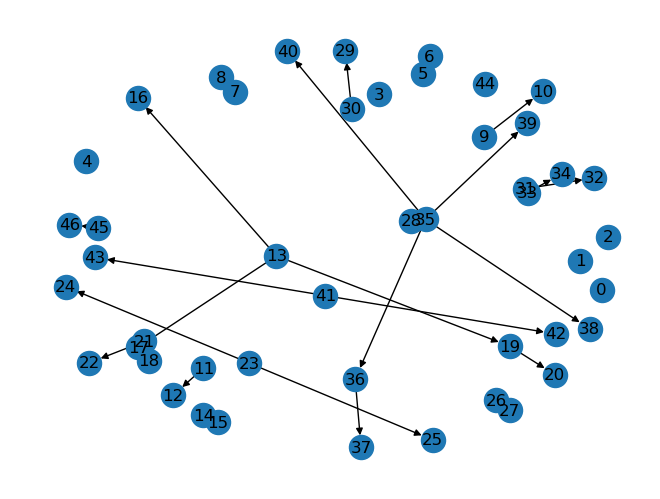

In [83]:
import networkx as nx
g = G.to_networkx()
nx.draw(g,with_labels=True)

In [84]:
G.ndata['h'] =feats

In [85]:
G.ndata

{'h': tensor([[-0.5135, -1.8189,  0.9909,  ..., -1.3841,  1.9964,  0.6938],
        [-0.6736, -2.4217,  1.4115,  ..., -2.5996, -0.1033,  1.2129],
        [ 1.7688, -0.6689, -0.3375,  ..., -1.6321,  1.2862, -0.2960],
        ...,
        [ 1.3295, -0.7958, -1.1448,  ..., -0.6168,  0.1610,  1.0041],
        [-1.3579,  3.4302, -0.0935,  ..., -0.7392,  1.1951,  1.3478],
        [ 1.4183, -0.9734, -0.4425,  ..., -0.6770,  1.8190,  0.5792]])}

In [86]:
model = MLPPredictor(G.ndata['h'].shape[1])

In [89]:
model(G,feats).shape

torch.Size([26])

In [102]:
G2 = dgl.DGLGraph()
G2.add_nodes(47)

/home/soham/miniconda3/envs/vrd-iu/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [104]:
node_pairs = torch.combinations(torch.arange(G2.num_nodes()),r=2)
G2.add_edges(node_pairs[:,0],node_pairs[:,1])
G2.add_edges(node_pairs[:,1],node_pairs[:,0])

In [105]:
node_pairs.shape

torch.Size([1081, 2])

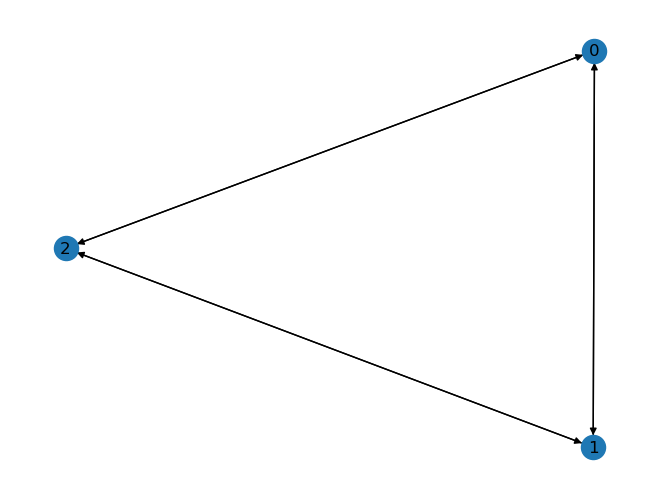

In [99]:
import networkx as nx
g = G2.to_networkx()
nx.draw(g,with_labels=True)

In [106]:
G2.edges()

(tensor([ 0,  0,  0,  ..., 45, 46, 46]),
 tensor([ 1,  2,  3,  ..., 44, 44, 45]))

In [107]:
scores = model(G2,feats)

In [108]:
scores.shape

torch.Size([2162])

In [109]:
possible_edges = G2.edges()
all_edges = [(possible_edges[0][idx], possible_edges[1][idx] ) for idx in range(G2.num_edges())]

In [111]:
p_edges = G.edges()
positive_edges = [(p_edges[0][idx], p_edges[1][idx]) for idx in range(G.num_edges())]

In [115]:
positive_indices = [idx for idx in range(len(all_edges)) if all_edges[idx] in positive_edges]

In [117]:
positive_indices

26

In [118]:
labels = torch.zeros(len(all_edges))
labels[positive_indices]=1

In [ ]:
labels

tensor(26.)

In [124]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [125]:
for epoch in range(100):
    scores = model(G2,feats)
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch} Loss: {loss}')

Epoch: 0 Loss: 0.4821370840072632
Epoch: 1 Loss: 9.421836853027344
Epoch: 2 Loss: 0.1027931421995163
Epoch: 3 Loss: 0.24829638004302979
Epoch: 4 Loss: 0.3043666481971741
Epoch: 5 Loss: 0.301500529050827
Epoch: 6 Loss: 0.2662358283996582
Epoch: 7 Loss: 0.2173415571451187
Epoch: 8 Loss: 0.16728997230529785
Epoch: 9 Loss: 0.12216683477163315
Epoch: 10 Loss: 0.08801114559173584
Epoch: 11 Loss: 0.08804447203874588
Epoch: 12 Loss: 0.07413918524980545
Epoch: 13 Loss: 0.06788262724876404
Epoch: 14 Loss: 0.07214763015508652
Epoch: 15 Loss: 0.06933894753456116
Epoch: 16 Loss: 0.06353525072336197
Epoch: 17 Loss: 0.06364788115024567
Epoch: 18 Loss: 0.06505966186523438
Epoch: 19 Loss: 0.06437698006629944
Epoch: 20 Loss: 0.06154046207666397
Epoch: 21 Loss: 0.058891672641038895
Epoch: 22 Loss: 0.057714253664016724
Epoch: 23 Loss: 0.05294961854815483
Epoch: 24 Loss: 0.05061683431267738
Epoch: 25 Loss: 0.050817880779504776
Epoch: 26 Loss: 0.05059709772467613
Epoch: 27 Loss: 0.04917435720562935
Epoch: 2

In [126]:
scores = model(G2,feats)

In [127]:
probs = F.sigmoid(scores)

In [144]:
pred = (probs>=0.5).int()

In [145]:
(pred == labels).sum()

tensor(2148)

In [146]:
len(all_edges)

2162

In [148]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels.detach().numpy(), scores.detach().numpy())

0.9939858830308269

In [149]:
len(data.keys())

571

In [8]:
from torch.utils.data import Dataset, DataLoader
import pickle
import dgl
import os
import torch
import numpy as np
class GraphDataset(Dataset):
    def __init__(self, pkl_file, feature_dir, test=False):
        super().__init__()
        with open(pkl_file,"rb") as f:
            self.data = pickle.load(f)
        self.feature_dir = feature_dir
        self.test = test
        self.docs = list(self.data.keys())

    def __len__(self):
        return len(self.data.keys())
    
    def load_feat(self,nodes):
        tensors = []
        for idx,node in enumerate(nodes):
            try:
                tensors.append(torch.load(f"{self.feature_dir}/{node}.pt",map_location=torch.device("cpu"),weights_only=False).unsqueeze(0))
            except:
                tensors.append(torch.zeros((1,1536)))
        return torch.cat(tensors,dim=0)
    
    def generate_edge_labels(self, components, possible_edges, nodes):
        edges_u = []
        edges_v = []
        for comp in components:
            if comp['relations']['parent']!=[]:
                edges_u.append(comp['relations']['parent'][0])
                edges_v.append(comp['object_id'])
        get_node_index = lambda x: nodes.index(x)
        zipped_p_edges = list(zip(list(map(get_node_index,edges_u)), list(map(get_node_index,edges_v))))
        zipped_edges = list(zip(possible_edges[0],possible_edges[1]))
        # print(zipped_edges)
        get_edge_index = lambda x: zipped_edges.index(x)
        positive_indices = list(map(get_edge_index,zipped_p_edges))
        labels = torch.zeros(len(zipped_edges))
        labels[positive_indices]=1
        return labels
        
    def __getitem__(self, index):
        doc = self.docs[index]
        components = self.data[doc]['components']
        nodes = sorted([comp['object_id'] for comp in components])
        feats = self.load_feat(nodes)
        edges = torch.combinations(torch.arange(len(nodes)), r=2) #NC2
        g = dgl.DGLGraph()
        g.add_nodes(len(nodes))
        g.add_edges(edges[:,0],edges[:,1])
        g.add_edges(edges[:,1],edges[:,0])
        if self.test:
            return g, feats, nodes
        labels = self.generate_edge_labels(components,g.edges(),nodes)
        return g, feats, nodes, labels
            

In [9]:
import torch
import torch.nn as nn
import dgl
import torch.nn.functional as F
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [2]:
dataset = GraphDataset('train_data.pkl','train_visual_features')

In [3]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset,[0.9,0.1])

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=lambda batch: batch[0])
val_dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=lambda batch: batch[0])

In [5]:
from tqdm import tqdm
for data in tqdm(train_dataloader):
    data

  0%|          | 0/514 [00:00<?, ?it/s]/home/soham/miniconda3/envs/vrd-iu/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
100%|██████████| 514/514 [23:45<00:00,  2.77s/it]   


In [25]:
for g, feat, nodes, labels in tqdm(val_dataloader):
    print(g, feat, nodes, labels)
    break

  0%|          | 0/57 [00:00<?, ?it/s]/home/soham/miniconda3/envs/vrd-iu/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
  0%|          | 0/57 [00:00<?, ?it/s]

Graph(num_nodes=53, num_edges=2756,
      ndata_schemes={}
      edata_schemes={}) tensor([[-1.4688, -2.1361,  1.8872,  ..., -2.4274,  0.5819,  1.1917],
        [-2.0242, -0.8725,  0.8831,  ..., -1.0288, -0.8205,  1.4596],
        [ 1.7721,  0.0444,  0.2839,  ..., -1.2139,  1.0206, -0.1244],
        ...,
        [-1.7613,  1.2278, -0.8789,  ..., -0.5335, -0.1988,  1.3170],
        [-1.6533,  0.8201, -1.1555,  ..., -1.0754, -0.7554,  0.2373],
        [-1.1284, -0.9977, -1.1646,  ..., -1.0313, -0.4424,  1.0587]]) [43447, 43448, 43449, 43450, 43451, 43452, 43453, 43454, 43455, 43456, 43457, 43458, 43459, 43460, 43461, 43462, 43463, 43464, 43465, 43466, 43467, 43468, 43469, 43470, 43471, 43472, 43473, 43474, 43475, 43476, 43477, 43478, 43479, 43480, 43481, 43482, 43483, 43484, 43485, 43486, 43487, 43488, 43489, 43490, 43491, 43492, 43493, 43494, 43495, 43496, 43497, 43498, 43499] tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [10]:
model = MLPPredictor(1536)
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in tqdm(range(10)):
    total_loss = 0.0
    model.train()
    for g, feats, nodes, labels in train_dataloader:
        scores = model(g,feats)
        loss = F.binary_cross_entropy_with_logits(scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    total_loss/=len(train_dataloader)
    print(f'Epoch: {epoch} Train Loss: {total_loss}')
    model.eval()
    total_loss = 0.0
    auc = 0.0
    with torch.no_grad():
        for g, feats, nodes, labels in val_dataloader:
            scores = model(g,feats)
            loss = F.binary_cross_entropy_with_logits(scores, labels)
            total_loss+=loss.item()
            auc+= roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
        total_loss/=len(val_dataloader)
        auc/=len(val_dataloader)
    print(f'Epoch: {epoch} Val Loss: {total_loss} AUC: {auc}')


  0%|          | 0/10 [00:00<?, ?it/s]/home/soham/miniconda3/envs/vrd-iu/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
